In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier as DTC
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

# ตั้งค่า random seed สำหรับการทำซ้ำ (reproducibility)
RANDOM_SEED = 2566

# Generate simulated dataset
Generate simulated 2-class data for binary classification with 2 features

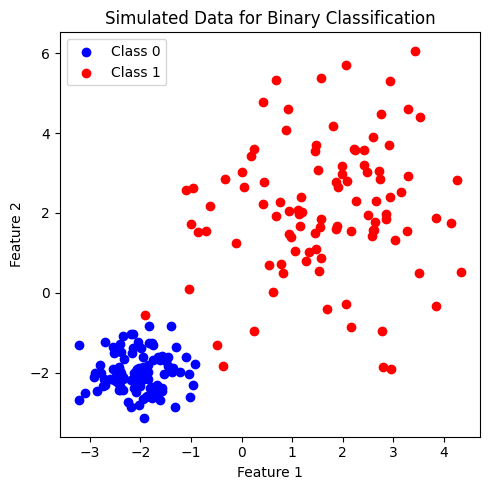

In [2]:
def generate_multi_class_dataset(n_classes, mean_class, std_class,n_samples):
    # สร้างชุดข้อมูลแบบ multi-class
    # ตั้งค่า random seed สำหรับการทำซ้ำ (reproducibility)
    np.random.seed(RANDOM_SEED)

    # กำหนด จำนวน features
    n_features = 2
    
    #  สร้างข้อมูล x สำหรับแต่ละคลาส
    x_data = []
    for label in range(n_classes):
        _ = np.random.normal(mean_class[label], std_class[label], (n_samples, n_features))
        x_data.append(_)

    # สร้างข้อมูล y หรือ labels สำหรับแต่ละคลาส
    y_data = []
    y_data.append(np.zeros(n_samples))
    for label in range(1, n_classes):
        y_data.append(label*np.ones(n_samples))

    # รวมข้อมูล x และ y จากทุกคลาส
    x = np.vstack((x_data))
    y = np.hstack(y_data)

    return x, y

# ทดลองสร้างข้อมูลโดยการเรียกใช้ generate_multi_class_dataset
# กำหนด จำนวนคลาส
n_classes = 2

# กำหนดช่วงค่า Mean และ standard deviation สำหรับแต่ละคลาส
mean_class = [[-2,-2], [2,2]]
std_class  = [[0.5,0.5], [1.5,1.5]] 

# กำหนดจำนวนข้อมูล สำหรับแต่ละคลาส
n_samples = 100

# ทำการสร้างชุดข้อมูล
x, y = generate_multi_class_dataset(n_classes, mean_class, std_class,n_samples)

# Plot ข้อมูล x, y ที่มีอยู่
plt.figure(figsize = (5,5))
plt.scatter(x[y==0, 0], x[y==0, 1], c='b', label='Class 0')
plt.scatter(x[y==1, 0], x[y==1, 1], c='r', label='Class 1')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Simulated Data for Binary Classification')
plt.legend()
plt.tight_layout()
plt.show()

# Decision Tree

Decision Tree (ต้นไม้การตัดสินใจ) เป็นอัลกอริทึมที่ใช้ในงานการจำแนกและทำนายข้อมูลในการเรียนรู้แบบ Supervised Learning โดยที่ข้อมูลจะถูกแบ่งออกเป็นกลุ่มย่อยๆ ด้วยเงื่อนไข (conditions) สอดคล้องกับคุณสมบัติของข้อมูล แล้วจึงสร้างต้นไม้เพื่อเลือกกลุ่มข้อมูลให้ถูกต้อง ต้นไม้การตัดสินใจประกอบด้วยโหนด (node) และลูก (leaf) โหนดจะแบ่งข้อมูลออกเป็นกลุ่มย่อยๆ โดยใช้เงื่อนไขต่างๆ ที่คัดเลือกคุณลักษณะหรือคุณสมบัติของข้อมูล และลูกจะแสดงผลลัพธ์หรือคลาสที่ทำนายได้จากกลุ่มข้อมูลที่อยู่ในโหนดนั้น การสร้างต้นไม้การตัดสินใจจะใช้วิธีการเลือกเงื่อนไขที่เหมาะสมที่สุดในการแบ่งข้อมูล เช่น Gini Index, Information Gain, หรือ Chi-square เพื่อทำให้การแบ่งข้อมูลมีความถูกต้องและมีประสิทธิภาพ


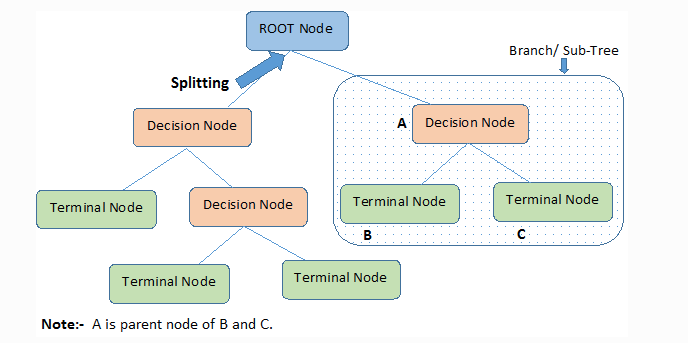
Decision tree [ที่มา](https://www.kdnuggets.com/2020/01/decision-tree-algorithm-explained.html)

Gini index และ entropy เป็นสองวิธีที่ใช้ในการวัดความไม่สุ่ม (impurity) ในต้นไม้การตัดสินใจ (decision tree) ซึ่งเป็นวิธีการแบ่งแยกข้อมูลในแต่ละโหนดของต้นไม้เพื่อการจัดลำดับคุณสมบัติ (feature) ในการตัดสินใจแบบการจำแนกคลาส (classification).

1. Gini index: Gini index ใช้วัดความไม่สุ่มในการแบ่งข้อมูลในโหนด มีสูตรดังนี้:

   Gini_index = 1 - Σ (pᵢ)²
   
   ที่ pᵢ คือความถี่ของคลาส i ในชุดข้อมูลที่กำลังพิจารณา
   
   Gini index มีค่าตั้งแต่ 0 ถึง 1 โดย Gini index เท่ากับ 0 หมายถึงความไม่สุ่มสำหรับคลาสในโหนดแน่นอน และ Gini index เท่ากับ 1 หมายถึงความสุ่มสำหรับคลาสในโหนด

2. Entropy: Entropy ใช้วัดความไม่สุ่มในการแบ่งข้อมูลในโหนด มีสูตรดังนี้:

   Entropy = - Σ (pᵢ * log₂(pᵢ))
   
   ที่ pᵢ คือความถี่ของคลาส i ในชุดข้อมูลที่กำลังพิจารณา
   
   Entropy มีค่าตั้งแต่ 0 ถึง 1 โดย Entropy เท่ากับ 0 หมายถึงความไม่สุ่มสำหรับคลาสในโหนดแน่นอน และ Entropy เท่ากับ 1 หมายถึงความสุ่มสำหรับคลาสในโหนด

ในการสร้างต้นไม้การตัดสินใจ, เราจะเลือกคุณสมบัติที่มี Gini index หรือ Entropy น้อยที่สุดหรือเป็นศูนย์ที่สุดเป็นผลลัพธ์ และใช้ค่านั้นในการแบ่งข้อมูลในโหนดในขั้นตอนต่อไปของการสร้างต้นไม้การตัดสินใจ นอกจากนั้นยังมีการทำ pruning ใน decision tree ซึ่งเป็นกระบวนการลดขนาดของต้นไม้การตัดสินใจ เพื่อลดความซับซ้อนของโมเดลและลดโอกาสการเกิด overfitting ซึ่งเป็นปัญหาที่พบได้บ่อยในอัลกอริธึมชนิดนี้ที่มีความลึกสูงหรือมีจำนวนของโหนดมากเกินไป กระบวนการ pruning มีวิธีการหลายวิธี แต่วิธีที่พบบ่อยที่สุดคือ การใช้ค่าความสูงของต้นไม้ (tree height) หรือค่าความซับซ้อนของโหนด (node complexity) เพื่อตัดสินใจว่าจะลบโหนดบางต้นหรือไม่

## DT Classification 

By default, the model will spit the tree until Gini impurity is zero.

Let's start with the easy problem



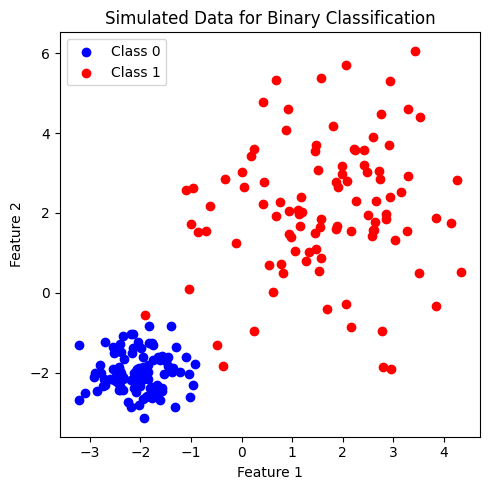

In [3]:
# ทดลองสร้างข้อมูลโดยการเรียกใช้ generate_multi_class_dataset
# กำหนด จำนวนคลาส
n_classes = 2

# กำหนดช่วงค่า Mean และ standard deviation สำหรับแต่ละคลาส
mean_class = [[-2,-2], [2,2]]
std_class  = [[0.5,0.5], [1.5,1.5]] 

# กำหนดจำนวนข้อมูล สำหรับแต่ละคลาส
n_samples = 100

# ทำการสร้างชุดข้อมูล
x, y = generate_multi_class_dataset(n_classes, mean_class, std_class,n_samples)

# Plot ข้อมูล x, y ที่มีอยู่
plt.figure(figsize = (5,5))
plt.scatter(x[y==0, 0], x[y==0, 1], c='b', label='Class 0')
plt.scatter(x[y==1, 0], x[y==1, 1], c='r', label='Class 1')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Simulated Data for Binary Classification')
plt.legend()
plt.tight_layout()
plt.show()

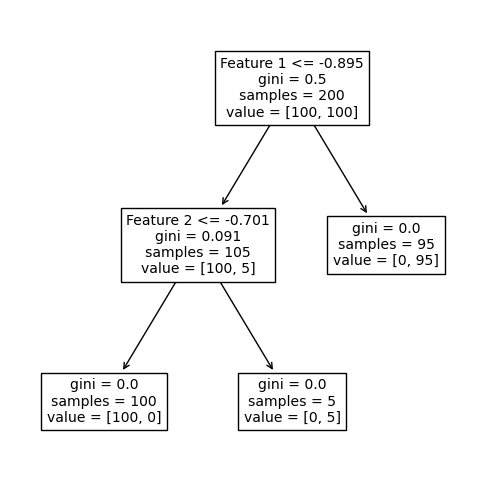

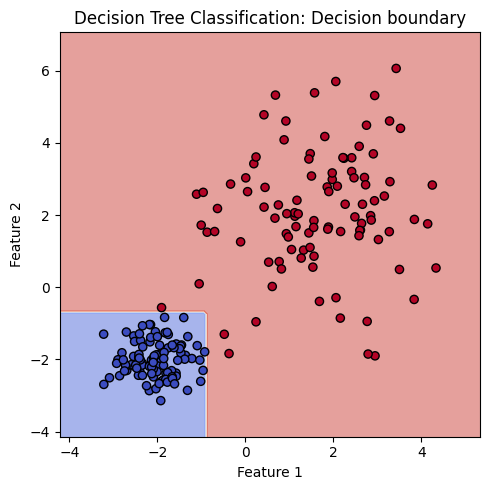

In [4]:
# สร้างชุดโมเดล
clf = DTC(random_state=RANDOM_SEED)

# สอนโมเดลจากข้อมูล x, y ที่สร้างขึ้นก่อนหน้านี้
clf.fit(x, y)

# Plot Decision Tree
plt.figure(figsize = (5,5))
tree.plot_tree(clf, feature_names=['Feature 1','Feature 2'])
plt.tight_layout()
plt.show()

# plot the decision boundary
plt.figure(figsize = (5,5))
ax = plt.gca()
DecisionBoundaryDisplay.from_estimator(clf,
                                       x,
                                       response_method="predict",
                                       cmap=plt.cm.coolwarm,
                                       alpha=0.5,
                                       ax=ax,
                                       xlabel='Feature 1',
                                       ylabel='Feature 2'
                                       )
ax.scatter(x[:, 0], x[:, 1], c=y, cmap=plt.cm.coolwarm, s=35, edgecolors='k')
plt.title('Decision Tree Classification: Decision boundary')
plt.tight_layout()
plt.show()

Tree making two split with two condition:
- Feature 1 < -0.895
- Feature 2 < -0.701,

showing two boundaries in the plot of decision boundary, separating two different labels

Next is more tricky dataset.

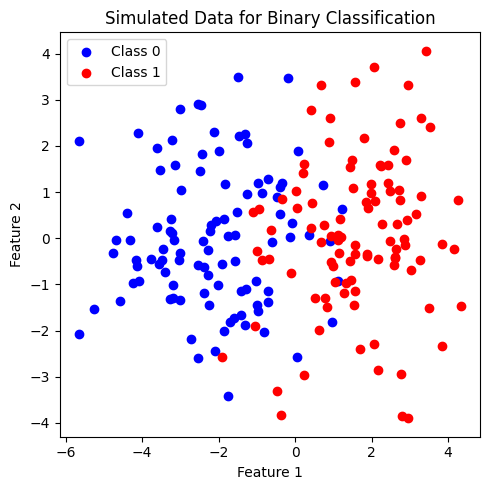

In [5]:
# ทดลองสร้างข้อมูลโดยการเรียกใช้ generate_multi_class_dataset
# กำหนด จำนวนคลาส
n_classes = 2

# กำหนดช่วงค่า Mean และ standard deviation สำหรับแต่ละคลาส
mean_class = [[-2,-0], [2,0]]
std_class  = [[1.5,1.5], [1.5,1.5]] 

# กำหนดจำนวนข้อมูล สำหรับแต่ละคลาส
n_samples = 100

# ทำการสร้างชุดข้อมูล
x, y = generate_multi_class_dataset(n_classes, mean_class, std_class,n_samples)

# Plot ข้อมูล x, y ที่มีอยู่
plt.figure(figsize = (5,5))
plt.scatter(x[y==0, 0], x[y==0, 1], c='b', label='Class 0')
plt.scatter(x[y==1, 0], x[y==1, 1], c='r', label='Class 1')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Simulated Data for Binary Classification')
plt.legend()
plt.tight_layout()
plt.show()

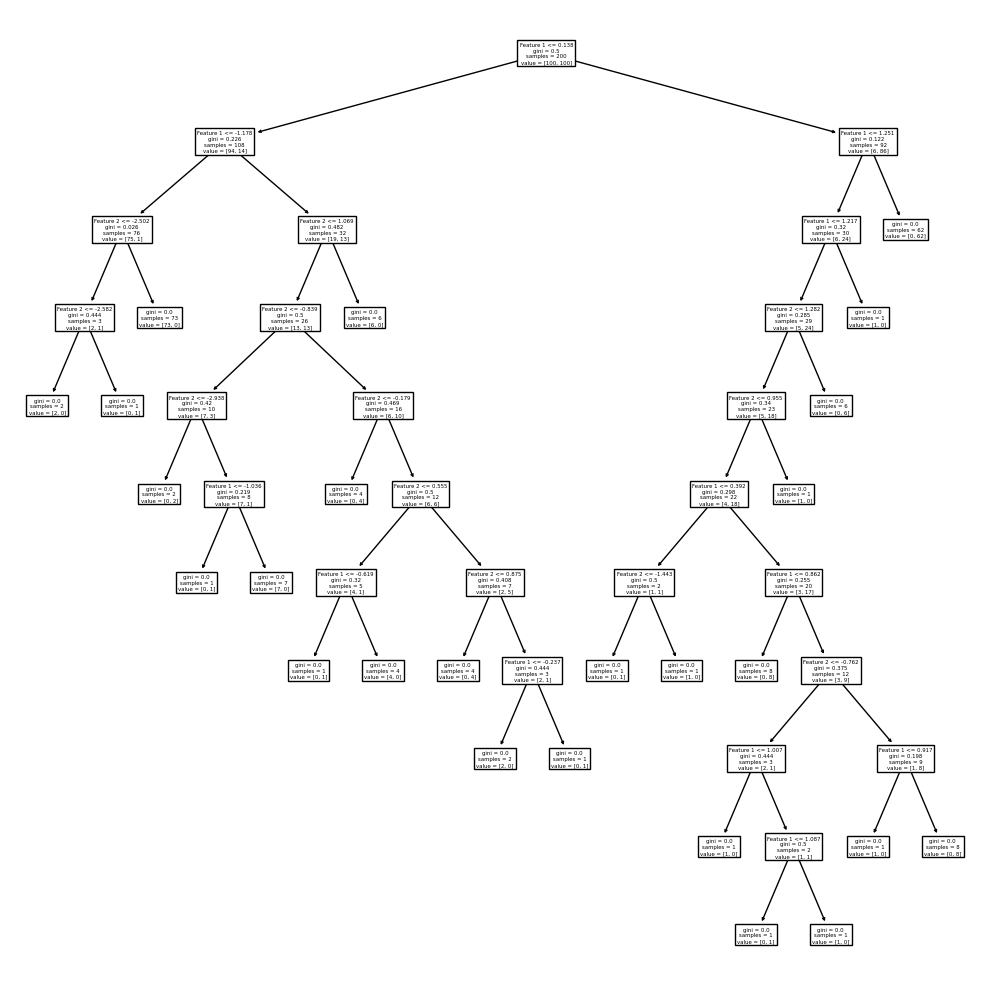

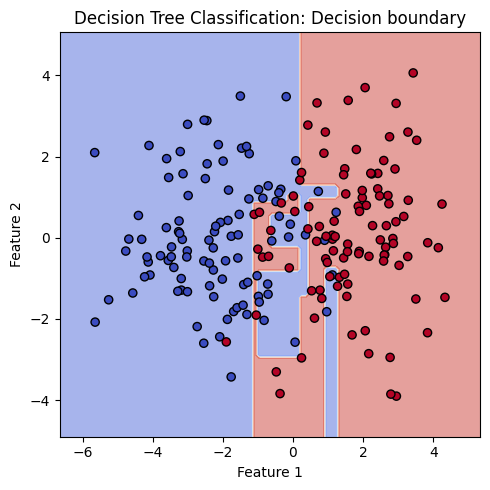

In [6]:
# สร้างชุดโมเดล
clf = DTC(random_state=RANDOM_SEED)

# สอนโมเดลจากข้อมูล x, y ที่สร้างขึ้นก่อนหน้านี้
clf.fit(x, y)

# Plot Decision Tree, showing decision path
plt.figure(figsize = (10,10))
tree.plot_tree(clf, feature_names=['Feature 1','Feature 2'])
plt.tight_layout()
plt.show()

# plot the decision boundary
plt.figure(figsize = (5,5))
ax = plt.gca()
DecisionBoundaryDisplay.from_estimator(clf,
                                       x,
                                       response_method="predict",
                                       cmap=plt.cm.coolwarm,
                                       alpha=0.5,
                                       ax=ax,
                                       xlabel='Feature 1',
                                       ylabel='Feature 2'
                                       )
ax.scatter(x[:, 0], x[:, 1], c=y, cmap=plt.cm.coolwarm, s=35, edgecolors='k')
plt.title('Decision Tree Classification: Decision boundary')
plt.tight_layout()
plt.show()

While decision trees are easy to interpret and visualize, but also very easy to be overfitting since the method is very sensitive to noisy data.

The nature of overfitting can be reduced by bagging, or ensemblw method.

The goal of ensemble methods is to combine the predictions of several base estimators built with a given learning algorithm in order to improve generalizability / robustness over a single estimator.

# Random Forest Classification

RF is the ensemble methods of randomized decision tree. The prediction of the ensemble is given as the averaged prediction of all individual classifiers.

Random forest (ป่าไม้สุ่ม) เป็นการผสมของ decision tree หลายๆ ต้นไม้เข้าด้วยกัน โดยการสร้างต้นไม้แต่ละต้นใน random forest จะใช้ชุดข้อมูลที่สุ่มมาจากตัวอย่างข้อมูลต้นฉบับ และใช้เทคนิคที่เรียกว่า bootstrap aggregating (หรือที่เรียกสั้น ๆ ว่า bagging) เพื่อสร้างความหลากหลายในต้นไม้แต่ละต้น นอกจากนี้ ในการสร้างต้นไม้แต่ละต้นใน random forest จะใช้เฟี้ยมอินพุตสุ่ม (random feature subset) เพื่อให้แต่ละต้นไม้มีการใช้ลักษณะ (feature) ที่แตกต่างกัน ความเชื่อมโยงระหว่าง decision tree และ random forest คือ random forest เป็นการส่งเสริม decision tree ให้มีประสิทธิภาพมากขึ้น ด้วยการสร้างความหลากหลายในต้นไม้แต่ละต้น การสุ่มข้อมูลตัวอย่างและลักษณะในการสร้างต้นไม้ช่วยลดความเกี่ยวข้องระหว่างต้นไม้ และลดโอกาสที่จะเกิด overfitting นอกจากนี้ random forest ยังสามารถใช้คะแนนความสำคัญของลักษณะ (feature importance)

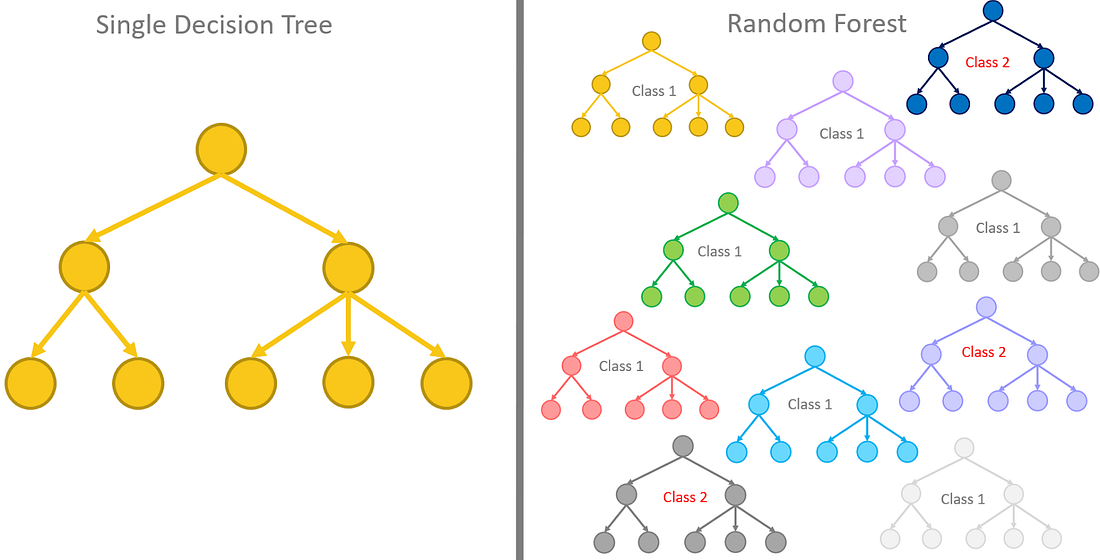
Random forest และ decision tree [ที่มา](https://towardsdatascience.com/from-a-single-decision-tree-to-a-random-forest-b9523be65147)

*Random forest* (ป่าไม้สุ่ม) เป็นการผสมของ decision tree หลายๆ ต้นไม้เข้าด้วยกัน โดยการสร้างต้นไม้แต่ละต้นใน random forest จะใช้ชุดข้อมูลที่สุ่มมาจากตัวอย่างข้อมูลต้นฉบับ และใช้เทคนิคที่เรียกว่า bootstrap aggregating (หรือที่เรียกสั้น ๆ ว่า bagging) เพื่อสร้างความหลากหลายในต้นไม้แต่ละต้น นอกจากนี้ ในการสร้างต้นไม้แต่ละต้นใน random forest จะใช้เฟี้ยมอินพุตสุ่ม (random feature subset) เพื่อให้แต่ละต้นไม้มีการใช้ลักษณะ (feature) ที่แตกต่างกัน ความเชื่อมโยงระหว่าง decision tree และ random forest คือ random forest เป็นการส่งเสริม decision tree ให้มีประสิทธิภาพมากขึ้น ด้วยการสร้างความหลากหลายในต้นไม้แต่ละต้น การสุ่มข้อมูลตัวอย่างและลักษณะในการสร้างต้นไม้ช่วยลดความเกี่ยวข้องระหว่างต้นไม้ และลดโอกาสที่จะเกิด overfitting นอกจากนี้ random forest ยังสามารถใช้คะแนนความสำคัญของลักษณะ (feature importance)

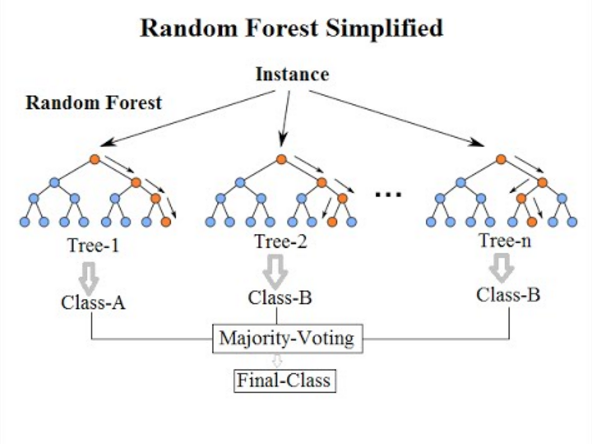
Random Forest ที่มา: Wikipedia.com

*Bagging (Bootstrap Aggregating)*
 เป็นเทคนิคที่ใช้ในการสร้าง random forest โดยการสุ่มสร้างชุดตัวอย่างข้อมูล (bootstrap sample) จากชุดข้อมูลต้นฉบับที่มีอยู่ โดยกระบวนการสุ่มนี้จะทำให้เกิดความหลากหลายในชุดข้อมูลที่ใช้ในการสร้างต้นไม้แต่ละต้นใน random forest

กระบวนการสร้างชุดตัวอย่างข้อมูลโดยใช้เทคนิค bagging มีขั้นตอนดังนี้:

สุ่มสร้างชุดตัวอย่างข้อมูล (bootstrap sample): จากชุดข้อมูลต้นฉบับที่มีขนาด N สำหรับแต่ละตัวอย่างในชุดตัวอย่างใหม่ จะเลือกตัวอย่างได้โดยการสุ่มลงในชุดตัวอย่างใหม่จำนวน N ครั้งโดยการสุ่มตัวอย่างแบบไม่คืน (sampling without replacement) ซึ่งอาจทำให้มีตัวอย่างบางตัวไม่ปรากฏในชุดตัวอย่างใหม่
สร้างต้นไม้ (decision tree): จากชุดตัวอย่างใหม่ที่ได้จากขั้นตอนที่ 1 โดยใช้วิธีการสร้างต้นไม้เช่น ID3, C4.5, CART หรืออื่น ๆ ตามที่กำหนด
ทำซ้ำขั้นตอนที่ 1-2 หลาย ๆ ครั้งเพื่อสร้างต้นไม้แต่ละต้นใน random forest
เมื่อสร้างต้นไม้แต่ละต้นใน random forest ขึ้นมาแล้ว ในขั้นตอนการทำนาย (prediction) random forest จะนำผลลัพธ์ที่ได้จากแต่ละต้นไม้มาบวกกันหรือหาค่าเฉลี่ย เพื่อให้ได้ผลลัพธ์ที่มีความถูกต้องและเสถียรภาพสูงขึ้น โดย random forest จะเหมาะสำหรับการจัดการกับปัญหาที่ซับซ้อนและมีความหลากหลายในลักษณะข้อมูล

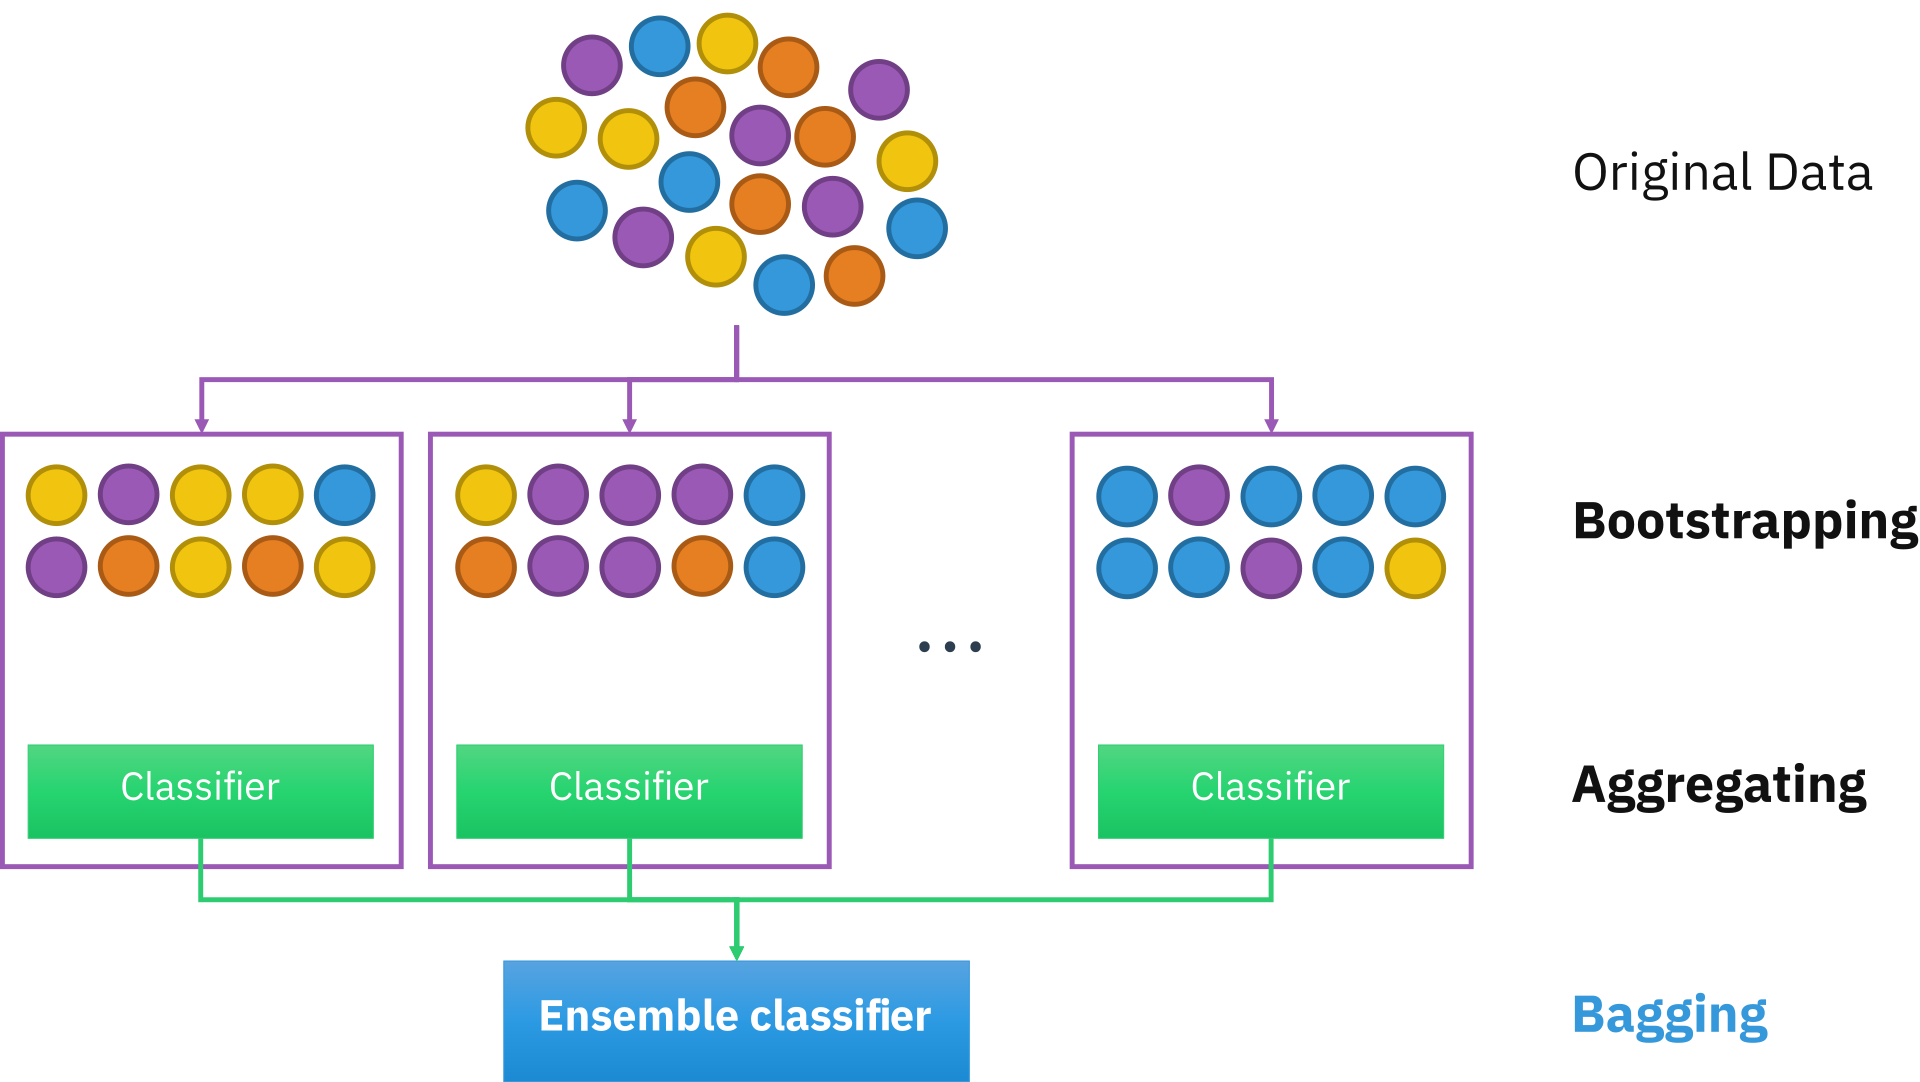

Ensemble baggin ที่มา: wikipedia.com

Number of Decision Trees: 100


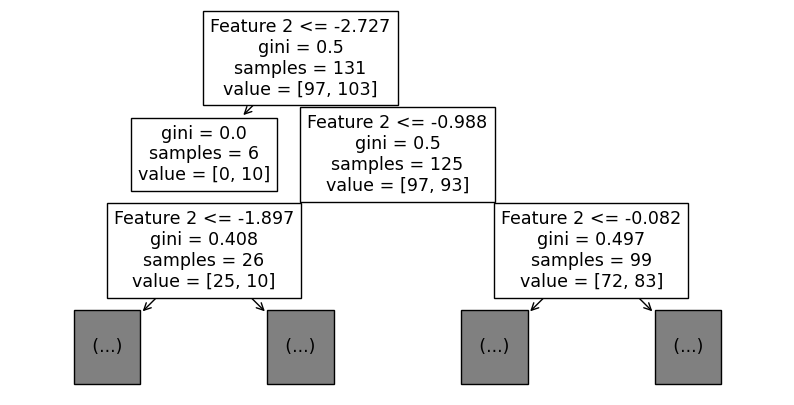

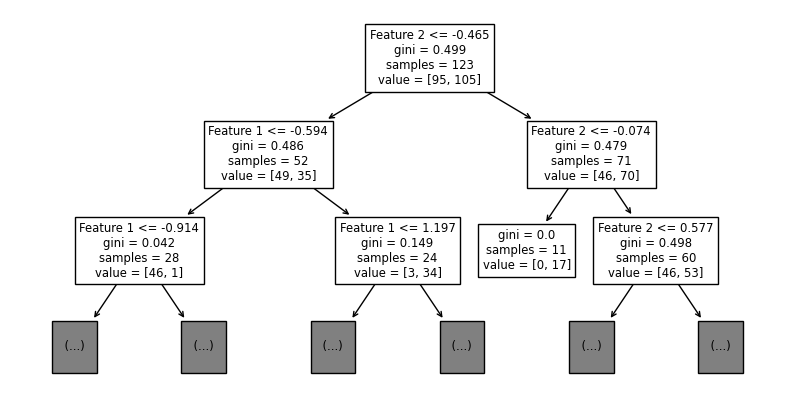

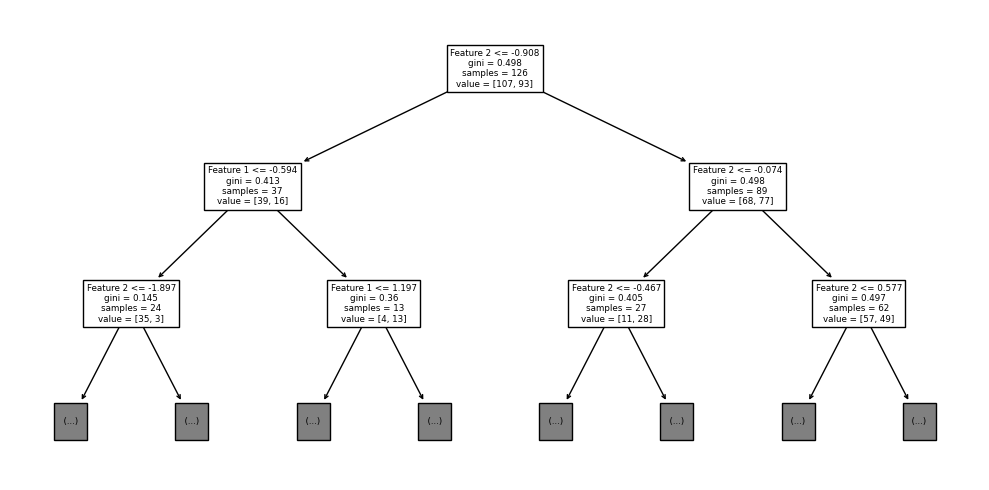

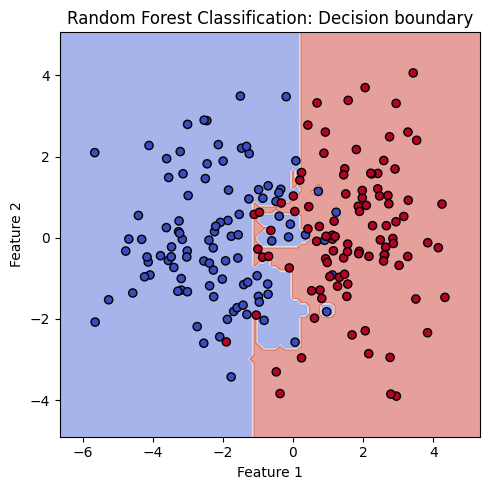

In [7]:
# สร้างชุดโมเดล
clf = RFC(random_state=RANDOM_SEED)

# สอนโมเดลจากข้อมูล x, y ที่สร้างขึ้นก่อนหน้านี้
clf.fit(x, y)

# แสดงจำนวนต้นไม้
print('Number of Decision Trees:',clf.n_estimators)

# Plot Decision Tree แสดง decision path ของต้นไม้ 3 ต้นแรก
for i in range(3):
    #tree_i = clf.estimators_[i]
    plt.figure(figsize = (10,5))
    tree.plot_tree(clf.estimators_[i],feature_names=['Feature 1','Feature 2'], max_depth=2)
plt.tight_layout()
plt.show()

# plot the decision boundary
plt.figure(figsize = (5,5))
ax = plt.gca()
DecisionBoundaryDisplay.from_estimator(clf,
                                       x,
                                       response_method="predict",
                                       cmap=plt.cm.coolwarm,
                                       alpha=0.5,
                                       ax=ax,
                                       xlabel='Feature 1',
                                       ylabel='Feature 2'
                                       )
ax.scatter(x[:, 0], x[:, 1], c=y, cmap=plt.cm.coolwarm, s=35, edgecolors='k')
plt.title('Random Forest Classification: Decision boundary')
plt.tight_layout()
plt.show()

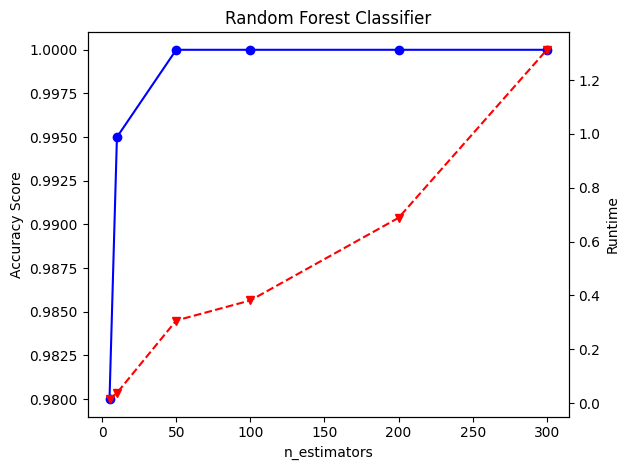

In [8]:
import time
# กำหนดช่วงค่าต้นไม้ หรือ n_estimators
n_estimators = [5,10,50,100,200,300]

# สร้างโมเดลด้วค่า C ต่างๆ ให้โมเดลเรียนรู้จากข้อมูล x, y ที่สร้างขึ้นก่อนหน้านี้ แล้วทดสอบโมเดลด้วย accuracy score
accuracy = []
runtimes = []
for n in n_estimators:

    start_time = time.time()  # เริ่มจับเวลา
    clf = RFC(n_estimators=n, random_state=RANDOM_SEED)
    clf.fit(x, y)
    runtimes.append((time.time() - start_time)) # หยุดจับเวลา

    # ทำนายค่า y โดยใช้โมเดล
    prediction = clf.predict(x)
    
    # คำนวณ accuracy score
    accuracy.append(accuracy_score(y, prediction))

# แสดงผล
fig, ax1 = plt.subplots()
ax1.plot(n_estimators, accuracy, 'bo-')
ax1.set_xlabel('n_estimators')
ax1.set_ylabel('Accuracy Score')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
plt.plot(n_estimators, runtimes, 'rv--')
#plt.yscale('log')
ax2.set_ylabel('Runtime')

plt.title('Random Forest Classifier')
plt.tight_layout()
plt.show()

Increse n_estimators significantly increase runtime. Considering the plot above, what would be the proper value of n_estimator that allow us to achieve high accuracy while minimize conputer runtime.

The maximum depth of the tree. If None, as the default value, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.

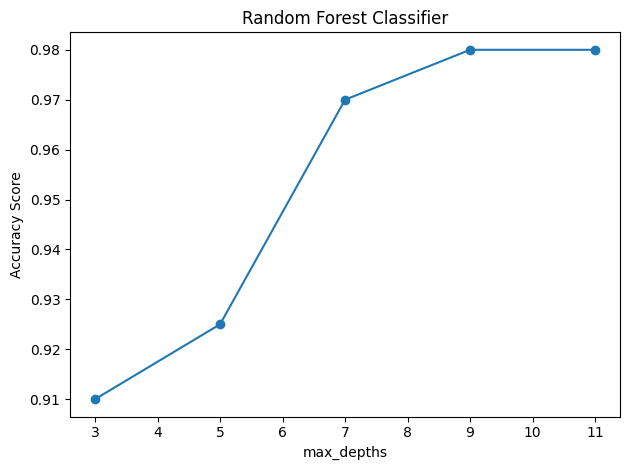

In [9]:
# กำหนดจำนวนต้นไม้ หรือ n_estimators
n_estimator = 5

# กำหนดความลึก (จำนวนชั้นกิ่ง) สูงสุดของต้นไม้
max_depths = [3,5,7,9,11]

# สร้างโมเดลด้วค่า C ต่างๆ ให้โมเดลเรียนรู้จากข้อมูล x, y ที่สร้างขึ้นก่อนหน้านี้ แล้วทดสอบโมเดลด้วย accuracy score
accuracy = []
for n in max_depths:
    clf = RFC(n_estimators=n_estimator, max_depth=n, random_state=RANDOM_SEED)
    clf.fit(x, y)

    # ทำนายค่า y โดยใช้โมเดล
    prediction = clf.predict(x)
    
    # คำนวณ accuracy score
    accuracy.append(accuracy_score(y, prediction))

# แสดงผล
plt.plot(max_depths, accuracy, marker='o')
#plt.xscale('log')
#plt.yscale('log')
plt.xlabel('max_depths')
plt.ylabel('Accuracy Score')
plt.title('Random Forest Classifier')
plt.tight_layout()
plt.show()

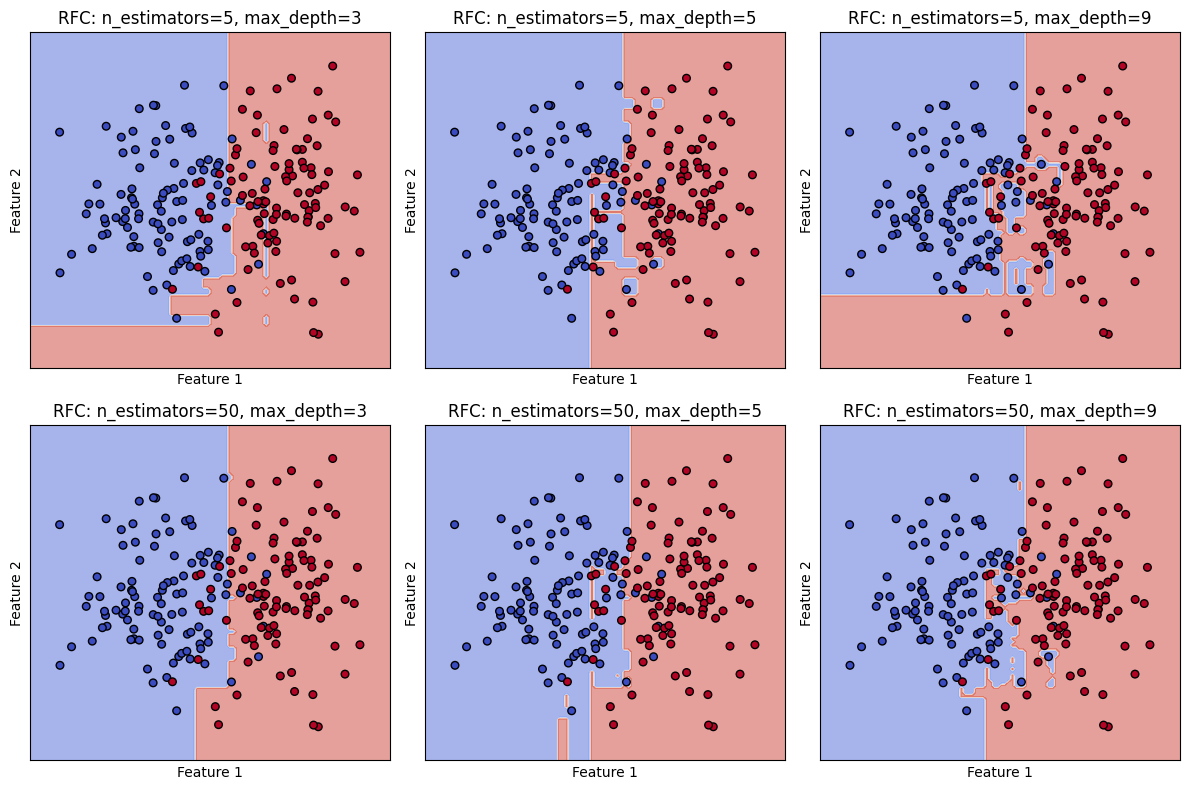

In [10]:
# สร้างชุดโมเดล
models = (RFC(n_estimators=5, max_depth=3),
          RFC(n_estimators=5, max_depth=5),
          RFC(n_estimators=5, max_depth=9),
          RFC(n_estimators=50, max_depth=3),
          RFC(n_estimators=50, max_depth=5),
          RFC(n_estimators=50, max_depth=9)
          )

# สอนโมเดลจากข้อมูล x, y ที่สร้างขึ้นก่อนหน้านี้
models = (clf.fit(x, y) for clf in models)

# ตั้งชื่อ plot ที่สอดคล้องกับชุดข้อมูล
titles = ['RFC: n_estimators=5, max_depth=3',
          'RFC: n_estimators=5, max_depth=5',
          'RFC: n_estimators=5, max_depth=9',
          'RFC: n_estimators=50, max_depth=3',
          'RFC: n_estimators=50, max_depth=5',
          'RFC: n_estimators=50, max_depth=9'
          ]

# plot the decision boundaries
fig, axes = plt.subplots(2,3, figsize=(4*3, 4*2))
for clf, title, ax in zip(models, titles, axes.flatten()):
    disp = DecisionBoundaryDisplay.from_estimator(clf,
                                                  x,
                                                  response_method="predict",
                                                  cmap=plt.cm.coolwarm,
                                                  alpha=0.5,
                                                  ax=ax,
                                                  xlabel='Feature 1',
                                                  ylabel='Feature 2',
                                                  )
    ax.scatter(x[:, 0], x[:, 1], c=y, cmap=plt.cm.coolwarm, s=30, edgecolors='k')
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(title)
plt.tight_layout()
plt.show()

Increase number of trees, or n_estimators, could alleviate the overfitting.

Too low max_depth could lead to underfitting, while too high max_depth could lead to overfitting.

## RFN Classification pipeline

### Generate 3-class dataset

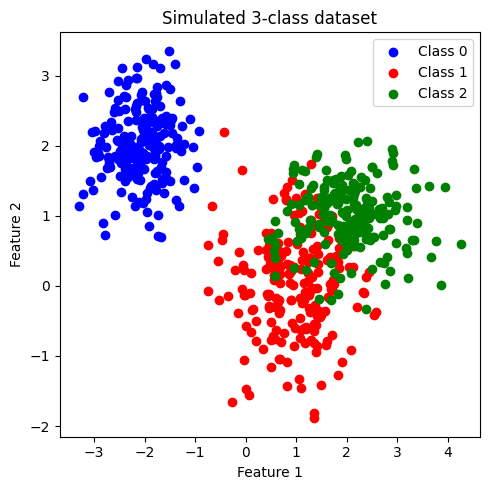

In [11]:
# สร้างข้อมูลโดยการเรียกใช้ generate_multi_class_dataset
# กำหนด จำนวนคลาส
n_classes = 3

# กำหนดช่วงค่า Mean และ standard deviation สำหรับแต่ละคลาส
mean_class = [[-2,2], [1,0], [2,1]]
std_class  = [[0.5,0.5], [0.75,0.75],[0.75,0.5]] 

# กำหนดจำนวนข้อมูล สำหรับแต่ละคลาส
n_samples = 200

# ทำการสร้างชุดข้อมูล
x, y = generate_multi_class_dataset(n_classes, mean_class, std_class,n_samples)

# Plot ข้อมูล x, y ที่สร้างขึ้น
plt.figure(figsize = (5,5))
color_list = ['b','r','g']
for label in range(n_classes):
    plt.scatter(x[y==label, 0], x[y==label, 1], c=color_list[label], label='Class '+str(label))
    
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Simulated 3-class dataset')
plt.legend()
plt.tight_layout()
plt.show()


### แบ่งข้อมูลเป็น train-test และ cross-validation
โดยไม่กำกับการแบ่งตามสัดส่วนคลาสของคำตอบ (stratification)

In [12]:
# สร้าง training data และ test data โดยแบ่งจากชุดข้อมูล x,y
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, 
                                                    stratify=None, 
                                                    shuffle=True,
                                                    random_state=RANDOM_SEED)

print('Train set: จำนวนข้อมูล แบ่งกลุ่มตาม class label')
unique, counts = np.unique(y_train, return_counts=True)
print(np.asarray((unique, counts)).T)

print('Test set: จำนวนข้อมูล แบ่งกลุ่มตาม class label')
unique, counts = np.unique(y_test, return_counts=True)
print(np.asarray((unique, counts)).T)

Train set: จำนวนข้อมูล แบ่งกลุ่มตาม class label
[[  0. 169.]
 [  1. 155.]
 [  2. 156.]]
Test set: จำนวนข้อมูล แบ่งกลุ่มตาม class label
[[ 0. 31.]
 [ 1. 45.]
 [ 2. 44.]]


In [13]:
# แบ่งข้อมูล training data ด้วย 5-fold cross-validation เพื่อ tune hyperparameter
#cv_splitter = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)

cv_splitter = KFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)

### ทำการ standardize ข้อมูลทั้งหมด
ใช้ mean และ SD จาก training set ในการ standardize test set เพื่อป้องกัน information leak

In [14]:
x_scaler = StandardScaler().fit(x_train)

x_train = x_scaler.transform(x_train)
x_test  = x_scaler.transform(x_test)

### เทรนโมเดล ด้วย base model (default hyperparameter)

Training Set: Classification report
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       169
         1.0       1.00      1.00      1.00       155
         2.0       1.00      1.00      1.00       156

    accuracy                           1.00       480
   macro avg       1.00      1.00      1.00       480
weighted avg       1.00      1.00      1.00       480


Test Set: Classification report
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        31
         1.0       0.80      0.91      0.85        45
         2.0       0.89      0.77      0.83        44

    accuracy                           0.88       120
   macro avg       0.90      0.89      0.89       120
weighted avg       0.89      0.88      0.88       120



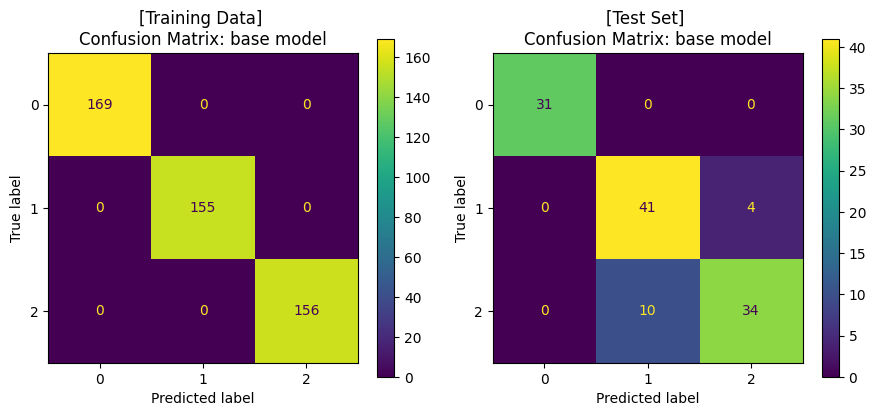

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4))

# สร้างโมเดล
base_clf = RFC(random_state=RANDOM_SEED)

# สอนโมเดลด้วย training data
base_clf.fit(x_train,y_train)

# ให้โมเดลทำนาย training data
y_pred = base_clf.predict(x_train)

# แสดงผล classification ของโมเดลจาก training data
print('Training Set: Classification report')
print(classification_report(y_train, y_pred))

# คำนวนและแสดงผล confusion matrix ของ training data
cm = confusion_matrix(y_train, y_pred)
display = ConfusionMatrixDisplay(confusion_matrix=cm)
display.plot(ax=ax1)
ax1.set_title('[Training Data] \nConfusion Matrix: base model')

# ให้โมเดลทำนาย test data
y_pred = base_clf.predict(x_test)

# แสดงผล classification ของโมเดล
print('\nTest Set: Classification report')
print(classification_report(y_test, y_pred))

# คำนวนและแสดงผล confusion matrix ของ test set
cm = confusion_matrix(y_test, y_pred)
display = ConfusionMatrixDisplay(confusion_matrix=cm)
display.plot(ax=ax2)
ax2.set_title('[Test Set] \nConfusion Matrix: base model')

plt.tight_layout()
plt.show()

### Hyperparameter tuning, then เทรนโมเดล ด้วย tuned model

We will tune key hyperparameters: 



Best hyperparameters: {'max_depth': 3, 'n_estimators': 100}
Best cross-validation score: 0.90
Training Set: Classification report
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       169
         1.0       0.91      0.81      0.86       155
         2.0       0.83      0.92      0.87       156

    accuracy                           0.91       480
   macro avg       0.91      0.91      0.91       480
weighted avg       0.92      0.91      0.91       480


Test Set: Classification report
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        31
         1.0       0.93      0.84      0.88        45
         2.0       0.85      0.93      0.89        44

    accuracy                           0.92       120
   macro avg       0.93      0.93      0.93       120
weighted avg       0.92      0.92      0.92       120



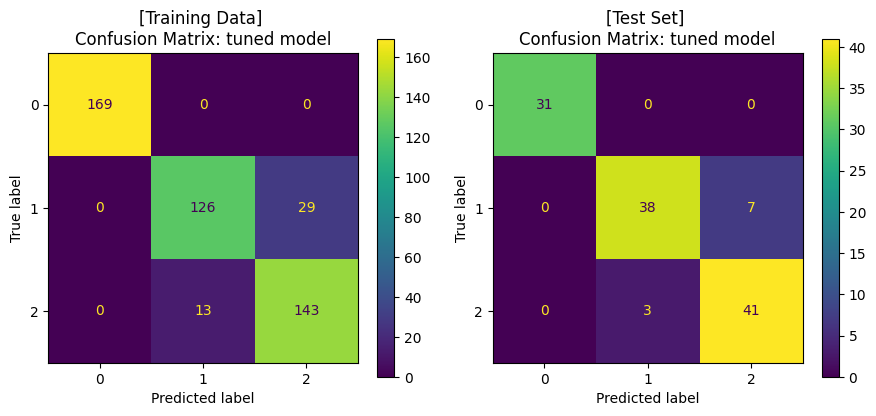

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4))

# กำหนดช่วงค่า hyperparameters ในรูปแบบ dictionary
clf_params = {'n_estimators': [10,50,100,200],
              'max_depth': [3, 5]
              }

# ใช้ GridSearchCV เพื่อสอนโมเดลจากชุดค่า hyperparameters จาก clf_params 
# และคำนวณค่า accuracy ของแต่ละโมเดล เพื่อเลือกชุด hyperparameters ที่ดีที่สุด
# โดยใช้เทคนิค cross-validation ในการแบ่งกลุ่ม validation data จาก training data
tuned_clf = GridSearchCV(estimator=base_clf, param_grid=clf_params, 
                             scoring=['accuracy'], refit='accuracy', cv=cv_splitter)

# fit โมเดลด้วย training data และ ให้โมเดลทำนายค่า y จาก training data
tuned_clf.fit(x_train, y_train)
y_pred = tuned_clf.predict(x_train)

# แสดงผล hyperparameters ที่ดีที่สุด และ cross-validation score
print('Best hyperparameters: {}'.format(tuned_clf.best_params_))
print("Best cross-validation score: {:.2f}".format(tuned_clf.best_score_))

# แสดงผล classification ของโมเดลจาก training data
print('Training Set: Classification report')
print(classification_report(y_train, y_pred))

# คำนวนและแสดงผล confusion matrix ของโมเดลจาก training data
cm = confusion_matrix(y_train, y_pred)
display = ConfusionMatrixDisplay(confusion_matrix=cm)
display.plot(ax=ax1)
ax1.set_title('[Training Data] \nConfusion Matrix: tuned model')

# ให้โมเดลทำนายค่า y จาก test data
y_pred = tuned_clf.predict(x_test)

# แสดงผล classification ของโมเดล จาก test data
print('\nTest Set: Classification report')
print(classification_report(y_test, y_pred))
# คำนวนและแสดงผล confusion matrix จาก test data
cm = confusion_matrix(y_test, y_pred)
display = ConfusionMatrixDisplay(confusion_matrix=cm)
display.plot(ax=ax2)
ax2.set_title('[Test Set] \nConfusion Matrix: tuned model')

plt.tight_layout()
plt.show()

Result: Improve accuracy